In [ ]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle as pk

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

In [ ]:
data = pd.read_csv('regional_data (1).csv', engine='python', skipfooter=3)
data = data.copy()

In [ ]:
columns_to_remove = ['Unnamed: 0', 'Température']
data = data.drop(columns_to_remove, axis=1)

In [ ]:
value_to_keep = 'Ile_de_France'
mask = data['Région'] == value_to_keep
data = data[mask]
data = data.drop('Région', axis=1)
column_length = len(data["Date - Heure"])
percentage = 0.2

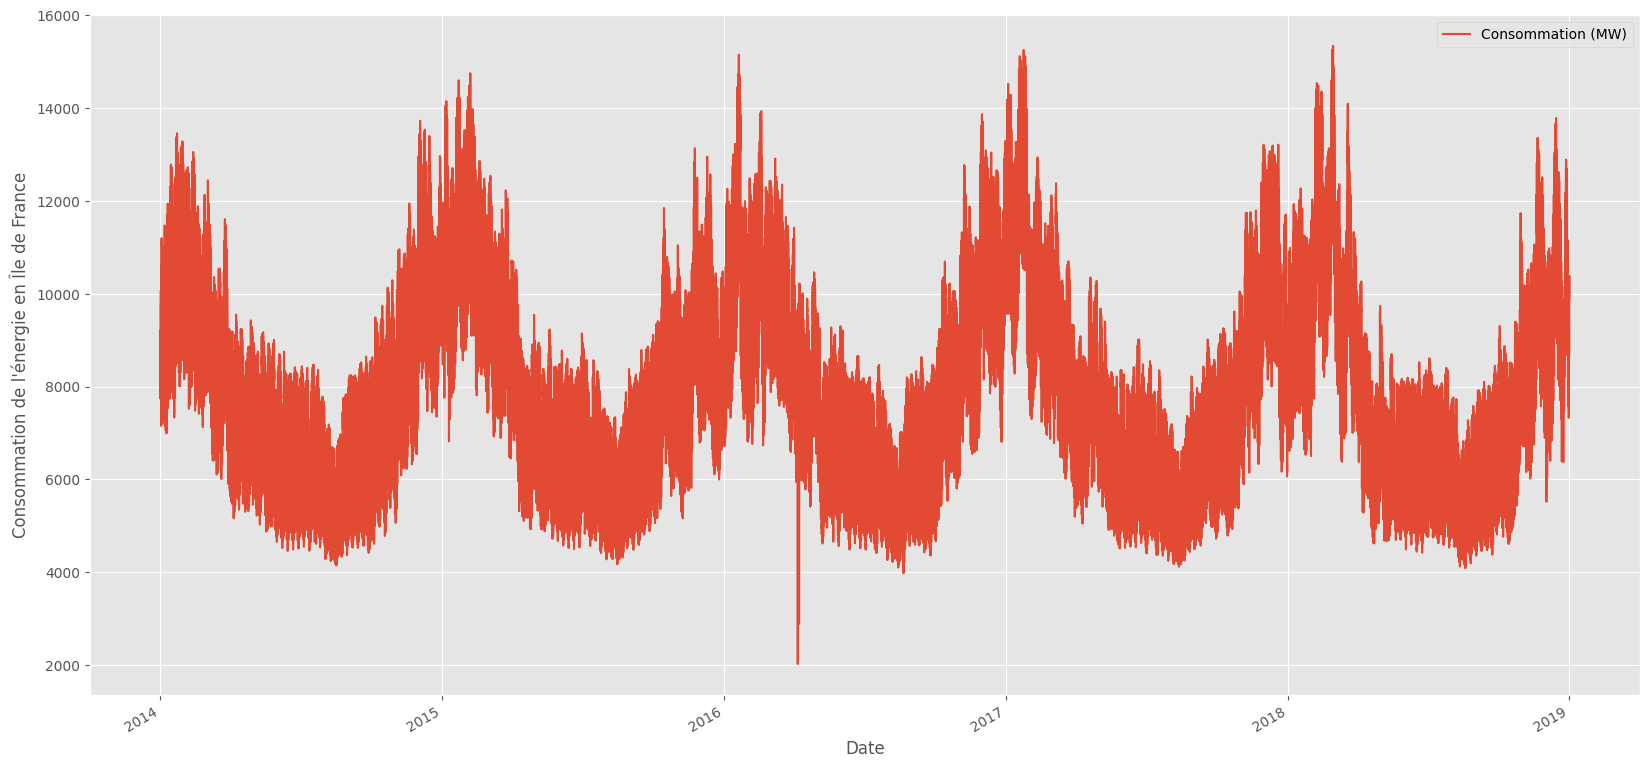

In [ ]:
# A bit of pre-processing to make it nicer
data['Date - Heure']=pd.to_datetime(data['Date - Heure'], format='%Y-%m-%dT%H:%M:%S%z')
data.set_index(['Date - Heure'], inplace=True)

# Plot the data
data.plot()
plt.ylabel("Consommation de l'énergie en Île de France")
plt.xlabel('Date')
plt.show()

In [ ]:
print(data)

                           Consommation (MW)
Date - Heure                                
2014-01-01 01:00:00+01:00               9164
2014-01-01 01:30:00+01:00               8887
2014-01-01 02:00:00+01:00               8623
2014-01-01 02:30:00+01:00               8556
2014-01-01 03:00:00+01:00               8284
...                                      ...
2018-12-31 20:00:00+01:00              10000
2018-12-31 20:30:00+01:00               9626
2018-12-31 21:00:00+01:00               9297
2018-12-31 21:30:00+01:00               8934
2018-12-31 22:00:00+01:00               8680

[87643 rows x 1 columns]


In [ ]:
start_index = int(column_length * (1 - percentage))
test_data = data["Consommation (MW)"].iloc[start_index:]
train_data = data["Consommation (MW)"].iloc[start_index-1000:start_index]
print(train_data)

Date - Heure
2017-12-10 22:00:00+01:00    10137
2017-12-10 22:30:00+01:00    10164
2017-12-10 23:00:00+01:00    10674
2017-12-10 23:30:00+01:00    10335
2017-12-11 00:00:00+01:00     9958
                             ...  
2017-12-31 15:30:00+01:00     7895
2017-12-31 16:00:00+01:00     7903
2017-12-31 16:30:00+01:00     7884
2017-12-31 17:00:00+01:00     8127
2017-12-31 17:30:00+01:00     8539
Name: Consommation (MW), Length: 1000, dtype: int64


In [ ]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [ ]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

In [ ]:
import pickle
with open('sarimax_results.pkl', 'wb') as file:
    pickle.dump(results, file)

In [ ]:
with open('Arima_1000_points.pkl', 'rb') as file:
    results = pk.load(file)

In [ ]:
pred1 = results.get_prediction(start=start_index-144,end = start_index, dynamic=True)
pred1_ci = pred1.conf_int()
predicted_values = pred1.predicted_mean
print(predicted_values)

NameError: ignored

In [ ]:
pred2 = results.get_forecast(200)
pred2_ci = pred2.conf_int()
predicted_values = pred2.predicted_mean
print(predicted_values)

2017-12-31 18:00:00+01:00    8771.801687
2017-12-31 18:30:00+01:00    8890.543790
2017-12-31 19:00:00+01:00    9047.378589
2017-12-31 19:30:00+01:00    9111.633361
2017-12-31 20:00:00+01:00    9099.700468
                                ...     
2018-01-04 19:30:00+01:00    9986.242176
2018-01-04 20:00:00+01:00    9966.086381
2018-01-04 20:30:00+01:00    9888.291948
2018-01-04 21:00:00+01:00    9739.530248
2018-01-04 21:30:00+01:00    9629.595107
Freq: 30T, Name: predicted_mean, Length: 200, dtype: float64


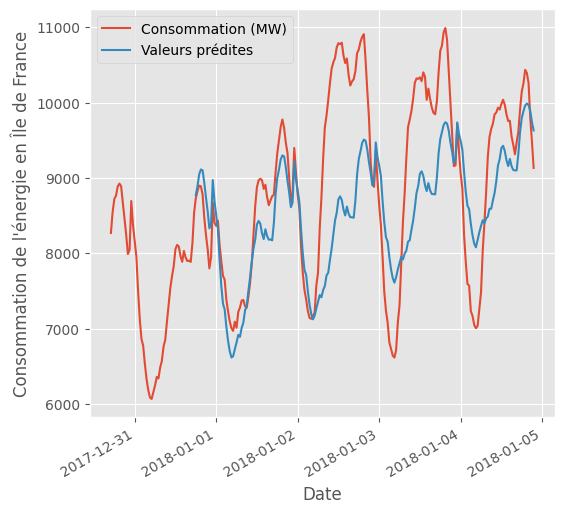

In [ ]:
ax = data.iloc[start_index-50:start_index+200].plot(figsize=(6, 6),label="Valeurs reel")
pred2.predicted_mean.plot(ax=ax, label='Valeurs prédites')
plt.ylabel("Consommation de l'énergie en Île de France")
plt.xlabel('Date')
plt.legend()
plt.show()